In [27]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

val_image_path = './training_all'
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = ('soccer/notebooks/'+val_image_path + '/' + root.find('filename').text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text),
                    #  int(root.find('size')[0].text),
                    #  int(root.find('size')[1].text),
                     member[0].text
                     )
            xml_list.append(value)
    column_name = ['path_to_image', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = os.path.join(os.getcwd(), 'Annotations')
    xml_df = xml_to_csv(val_image_path)
    xml_df.to_csv('annotations.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


In [7]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import csv

def generate_class_mapping():
    class_map_list = []
    fieldnames =  ['path_to_image','xmin','ymin','xmax','ymax','class']
    i = 0
    with open('./annotations.csv', 'r') as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=fieldnames)
        next(reader)
        for line, row in enumerate(reader):
            #print(row['class'])
            value = (row['class'], i)
            i += 1
            class_map_list.append(value)
    column_name = ['class', 'id']
    df = pd.DataFrame(class_map_list, columns=column_name)
    return df


def main():
    df = generate_class_mapping()
    df.to_csv('class_mappings.csv', index=None)
    # image_path = os.path.join(os.getcwd(), 'Annotations')
    # xml_df = xml_to_csv(image_path)
    # xml_df.to_csv('annotations.csv', index=None)
    # print('Successfully converted xml to csv.')


main()

In [25]:
import numpy as np
df = generate_class_mapping()
df = pd.unique(df['class'])
df = pd.DataFrame({'class':df,'id':np.arange(len(df))})
df.head()

,class,id
0,player,0
1,ball,1
2,referee,2
3,goalie,3
4,manager,4


In [26]:
df.to_csv('class_mappings.csv', index=None)

In [28]:
from tqdm import tqdm


In [29]:
import fastprogress

In [30]:
from fastprogress import master_bar, progress_bar
from time import sleep
mb = master_bar(range(10))

for i in range(0,100):
    for j in range(0,50):
        sleep(0.001)
    mb.update(i)
        

In [32]:
from fastprogress import master_bar, progress_bar
from time import sleep
mb = master_bar(range(10))
for i in mb:
    for j in progress_bar(range(100), parent=mb):
        sleep(0.01)
        mb.child.comment = f'second bar stat'
    mb.first_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')

TypeError: __init__() got an unexpected keyword argument 'display'

In [1]:
!pwd

/home/ewaymao/retinanet-pytorch-1.0/soccer/notebooks


In [2]:
%cd ../..

/home/ewaymao/retinanet-pytorch-1.0


In [3]:
import numpy as np
%matplotlib inline
import torchvision
import time
import os
import copy
import pdb
import time
import argparse

import sys
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

from dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, UnNormalizer, Normalizer


#assert torch.__version__.split('.')[1] == '4'

print('CUDA available: {}'.format(torch.cuda.is_available()))


def main(args=None):
    parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

    #parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
    #parser.add_argument('--coco_path', help='Path to COCO directory')
    #parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
    #parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')

    #parser.add_argument('--model', help='Path to model (.pt) file.')
    
    #parser = parser.parse_args(args)
    parser.dataset = 'csv'
    parser.csv_classes = 'soccer/notebooks/class_mappings.csv'
    parser.csv_val = 'soccer/notebooks/annotations.csv'
    parser.model = 'model_final.pt'
    
    if parser.dataset == 'coco':
        dataset_val = CocoDataset(parser.coco_path, set_name='val2017', transform=transforms.Compose([Normalizer(), Resizer()]))
    elif parser.dataset == 'csv':
        dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes, transform=transforms.Compose([Normalizer(), Resizer()]))
    else:
        raise ValueError('Dataset type not understood (must be csv or coco), exiting.')

    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=1, collate_fn=collater, batch_sampler=sampler_val)

    retinanet = torch.load(parser.model)
    #retinanet = model.resnet50(num_classes=80,)
    #retinanet.load_state_dict(torch.load('coco_resnet50_statedict.pt'))

    retinanet.eval()

    unnormalize = UnNormalizer()

    def draw_caption(image, box, caption):

        b = np.array(box).astype(int)
        cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
        cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)


    

    for idx, data in enumerate(dataloader_val):

        with torch.no_grad():
            st = time.time()
            scores, classification, transformed_anchors = retinanet(data['img'].float())
            print('Elapsed time: {}'.format(time.time()-st))

            #breakpoint()
            if idx >= 1: break
            
            idxs = np.where(scores>0.1)                                                    
            img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

            img[img<0] = 0
            img[img>255] = 255

            img = np.transpose(img, (1, 2, 0))

            img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]
                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = int(bbox[2])
                y2 = int(bbox[3])
                label_name = dataset_val.labels[int(classification[idxs[0][j]])]
                draw_caption(img, (x1, y1, x2, y2), label_name)

                cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
                print(label_name)

            cv2.imshow('img', img)
            cv2.waitKey(0)



if __name__ == '__main__':
    main()

CUDA available: False
Elapsed time: 2.373469591140747
Elapsed time: 2.402557611465454


In [1]:
!pwd

/home/ewaymao/retinanet-pytorch-1.0/soccer/notebooks


In [3]:
!ls training_all/

10801.jpg  16531.xml  22621.jpg  3501.xml  4251.jpg  5801.xml  8701.jpg
10801.xml  17401.jpg  22621.xml  3601.jpg  4251.xml  6091.jpg  8701.xml
14211.jpg  17401.xml  241.jpg	 3601.xml  4641.jpg  6091.xml  8881.jpg
14211.xml  17691.jpg  241.xml	 3751.jpg  4641.xml  6381.jpg  8881.xml
14501.jpg  17691.xml  2611.jpg	 3751.xml  4931.jpg  6381.xml  8991.jpg
14501.xml  17981.jpg  2611.xml	 3841.jpg  4931.xml  6961.jpg  8991.xml
14791.jpg  17981.xml  2751.jpg	 3841.xml  5281.jpg  6961.xml  9281.jpg
14791.xml  18271.jpg  2751.xml	 4001.jpg  5281.xml  7831.jpg  9281.xml
15081.jpg  18271.xml  3001.jpg	 4001.xml  5511.jpg  7831.xml  9571.jpg
15081.xml  2001.jpg   3001.xml	 4061.jpg  5511.xml  8411.jpg  9571.xml
15371.jpg  2001.xml   3251.jpg	 4061.xml  5751.jpg  8411.xml
15371.xml  20881.jpg  3251.xml	 4081.jpg  5751.xml  8641.jpg
16531.jpg  20881.xml  3501.jpg	 4081.xml  5801.jpg  8641.xml


In [5]:
!ls training_all/ | grep xml > xml_list

In [6]:
!cat xml_list

10801.xml
14211.xml
14501.xml
14791.xml
15081.xml
15371.xml
16531.xml
17401.xml
17691.xml
17981.xml
18271.xml
2001.xml
20881.xml
22621.xml
241.xml
2611.xml
2751.xml
3001.xml
3251.xml
3501.xml
3601.xml
3751.xml
3841.xml
4001.xml
4061.xml
4081.xml
4251.xml
4641.xml
4931.xml
5281.xml
5511.xml
5751.xml
5801.xml
6091.xml
6381.xml
6961.xml
7831.xml
8411.xml
8641.xml
8701.xml
8881.xml
8991.xml
9281.xml
9571.xml


In [1]:
import xml

In [1]:
import os
import xml.etree.ElementTree as ET
import xmltodict
import json
from xml.dom import minidom
from collections import OrderedDict


#attrDict = {"images":[{"file_name":[],"height":[], "width":[],"id":[]}], "type":"instances", "annotations":[], "categories":[]}

#xmlfile = "000023.xml"


def generateVOC2Json(rootDir,xmlFiles):
    #breakpoint()
    attrDict = dict()
    #images = dict()
    #images1 = list()
    attrDict["categories"]=[{"supercategory":"none","id":0,"name":"player"},
                    {"supercategory":"none","id":1,"name":"ball"},
                    {"supercategory":"none","id":2,"name":"referee"},
                    {"supercategory":"none","id":3,"name":"goalie"},
                {"supercategory":"none","id":4,"name":"manager"},
                {"supercategory":"none","id":5,"name":"cameraman"}]
    images = list()
    annotations = list()
    for root, dirs, files in os.walk(rootDir):
        image_id = 0
        for file in xmlFiles:
            image_id = image_id + 1
            
            #breakpoint()
            if file in files:
                
                #image_id = image_id + 1
                annotation_path = os.path.abspath(os.path.join(root, file))
                #breakpoint()
                
                #tree = ET.parse(annotation_path)#.getroot()
                image = dict()
                #keyList = list()
                doc = xmltodict.parse(open(annotation_path).read())
                #print doc['annotation']['filename']
                image['file_name'] = "training_all/" + str(doc['annotation']['filename'])
                #keyList.append("file_name")
                image['height'] = int(doc['annotation']['size']['height'])
                #keyList.append("height")
                image['width'] = int(doc['annotation']['size']['width'])
                #keyList.append("width")

                #image['id'] = str(doc['annotation']['filename']).split('.jpg')[0]
                image['id'] = image_id
                print("File Name: {} and image_id {}".format(file, image_id))
                images.append(image)
                # keyList.append("id")
                # for k in keyList:
                #     images1.append(images[k])
                # images2 = dict(zip(keyList, images1))
                # print images2
                #print images

                #attrDict["images"] = images

                #print attrDict
                #annotation = dict()
                id1 = 1
                if 'object' in doc['annotation']:
                    for obj in doc['annotation']['object']:
                        for value in attrDict["categories"]:
                            annotation = dict()
                            #if str(obj['name']) in value["name"]:
                            if str(obj['name']) == value["name"]:
                                #print str(obj['name'])
                                #annotation["segmentation"] = []
                                annotation["iscrowd"] = 0
                                #annotation["image_id"] = str(doc['annotation']['filename']).split('.jpg')[0] #attrDict["images"]["id"]
                                annotation["image_id"] = image_id
                                x1 = int(obj["bndbox"]["xmin"])  - 1
                                y1 = int(obj["bndbox"]["ymin"]) - 1
                                x2 = int(obj["bndbox"]["xmax"]) - x1
                                y2 = int(obj["bndbox"]["ymax"]) - y1
                                annotation["bbox"] = [x1, y1, x2, y2]
                                annotation["area"] = float(x2 * y2)
                                annotation["category_id"] = value["id"]
                                annotation["ignore"] = 0
                                annotation["id"] = id1
                                annotation["segmentation"] = [[x1,y1,x1,(y1 + y2), (x1 + x2), (y1 + y2), (x1 + x2), y1]]
                                id1 +=1

                                annotations.append(annotation)
                
                else:
                    print("File: {} doesn't have any object".format(file))
                #image_id = image_id + 1
                
            else:
                print("File: {} not found".format(file))
            

    attrDict["images"] = images    
    attrDict["annotations"] = annotations
    attrDict["type"] = "instances"

    #print attrDict
    jsonString = json.dumps(attrDict)
    with open("soccer_annotations.json", "w") as f:
        f.write(jsonString)

# rootDir = "/netscratch/pramanik/OBJECT_DETECTION/detectron/lib/datasets/data/Receipts/Annotations"
# for root, dirs, files in os.walk(rootDir):
#     for file in files:
#         if file.endswith(".xml"):
#             annotation_path = str(os.path.abspath(os.path.join(root,file)))
#             #print(annotation_path)
#             generateVOC2Json(annotation_path)
trainFile = "xml_list"
trainXMLFiles = list()
with open(trainFile, "rb") as f:
    #breakpoint()
    for line in f:
        fileName = line.strip().decode('ascii')
        print(fileName)
        trainXMLFiles.append(fileName)


rootDir = "./training_all/"
generateVOC2Json(rootDir, trainXMLFiles)
print('done')

10801.xml
14211.xml
14501.xml
14791.xml
15081.xml
15371.xml
16531.xml
17401.xml
17691.xml
17981.xml
18271.xml
2001.xml
20881.xml
22621.xml
241.xml
2611.xml
2751.xml
3001.xml
3251.xml
3501.xml
3601.xml
3751.xml
3841.xml
4001.xml
4061.xml
4081.xml
4251.xml
4641.xml
4931.xml
5281.xml
5511.xml
5751.xml
5801.xml
6091.xml
6381.xml
6961.xml
7831.xml
8411.xml
8641.xml
8701.xml
8881.xml
8991.xml
9281.xml
9571.xml
File Name: 10801.xml and image_id 1
File Name: 14211.xml and image_id 2
File Name: 14501.xml and image_id 3
File Name: 14791.xml and image_id 4
File Name: 15081.xml and image_id 5
File Name: 15371.xml and image_id 6
File Name: 16531.xml and image_id 7
File Name: 17401.xml and image_id 8
File Name: 17691.xml and image_id 9
File Name: 17981.xml and image_id 10
File Name: 18271.xml and image_id 11
File Name: 2001.xml and image_id 12
File Name: 20881.xml and image_id 13
File Name: 22621.xml and image_id 14
File Name: 241.xml and image_id 15
File Name: 2611.xml and image_id 16
File Name: 27

# RetinaNet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [5]:
soccerPics = Path('./training_all/')
soccerPics

PosixPath('training_all')

In [6]:
images, lbl_bbox = get_annotations('soccer_annotations.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[str(soccerPics/o.name)]

In [7]:
get_y_func(soccerPics)

KeyError: 'training_all/training_all'

In [11]:
images[0]

'training_all/10801.jpg'

In [12]:
size = (704,1280)
bs = 8

In [18]:
data = (ObjectItemList.from_folder(soccerPics)
        #Where are the images? -> in coco
        .random_split_by_pct(valid_pct=0.2)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
#data = data.normalize()

Pytorch's transforms.Resize(size) equivalent is implemented without an explicit transform function in fastai. It's done via the arguments size and resize_method.

The size argument can be either a single int 224, or a tuple of ints (224,400). The default behavior is to crop the image to a square when a single int is passed and to squish it in the case of a tuple, so that:

if size=224 is passed, it will resize and then crop to (224,224)
if size=(224,400) is passed, it will squish it to (224,400)
if size=(224,224) ==is passed, it will squish (not crop!) it to (224,224)
You can override the default resize_method.

In [19]:
type(img2bbox['training_all/10801.jpg'][0][0][0])

int

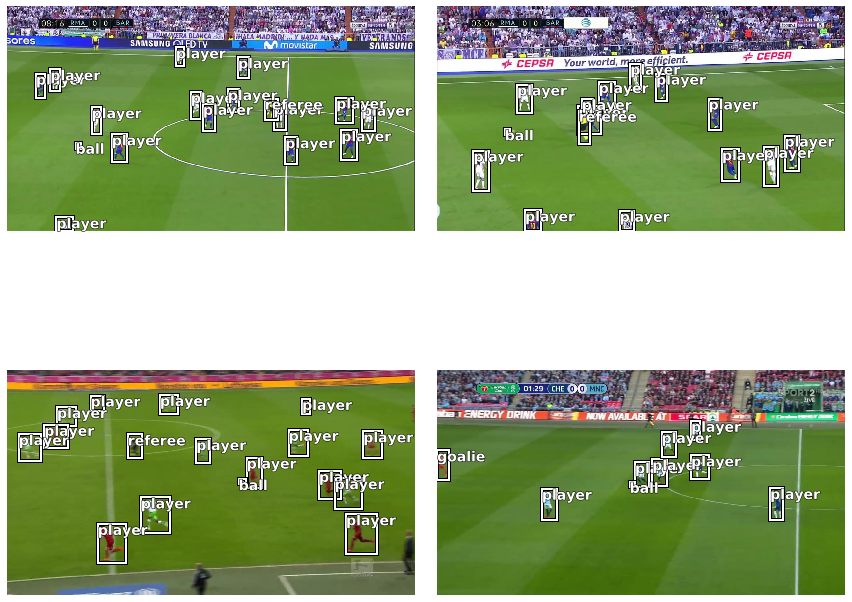

In [20]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(12,12))

In [21]:

anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.35, 0.5, 0.6])
anchors

tensor([[-0.9688, -0.9688,  0.0875,  0.0875],
        [-0.9688, -0.9688,  0.1250,  0.1250],
        [-0.9688, -0.9688,  0.1500,  0.1500],
        ...,
        [ 0.9688,  0.9688,  0.0875,  0.0875],
        [ 0.9688,  0.9688,  0.1250,  0.1250],
        [ 0.9688,  0.9688,  0.1500,  0.1500]])

In [22]:
for i, bbox in enumerate(anchors[:3]):
    bb = bbox.numpy()
    print(bb)

[-0.96875 -0.96875  0.0875   0.0875 ]
[-0.96875 -0.96875  0.125    0.125  ]
[-0.96875 -0.96875  0.15     0.15   ]


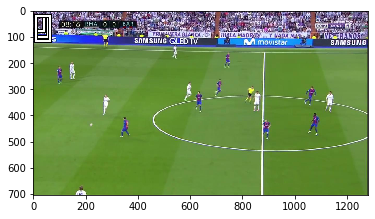

In [23]:
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:3]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size[0] / 2 
    y = (bb[1] + 1) * size[1] / 2 
    w = bb[2] * size[0] / 2
    h = bb[3] * size[1] / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

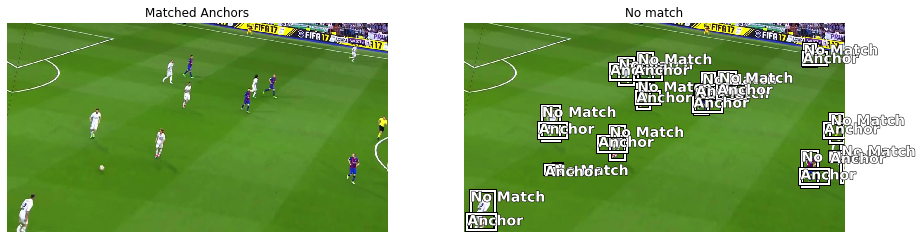

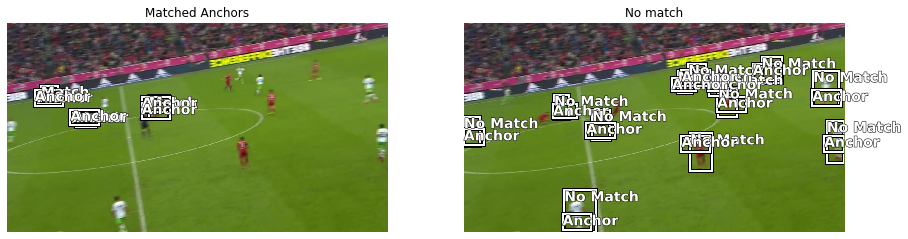

In [167]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(15,15))

In [24]:
n_classes = data.train_ds.c
n_classes

7

In [25]:

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=32, final_bias=-4., n_conv=2)
model.eval()

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [26]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [27]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [28]:
len(learn.data.train_dl)

4

In [20]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: can't alloc

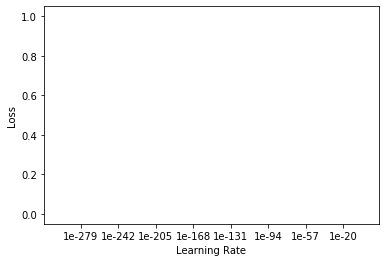

In [21]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-ball,AP-cameraman,AP-goalie,AP-manager,AP-player,AP-referee,time


RuntimeError: can't alloc

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [ ]:
data.train_ds.classes

In [ ]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=5)

In [ ]:
learn.save('stage1')

In [ ]:
learn.load('stage1')

In [ ]:
learn = load_learner(mnist)

In [ ]:
img = data.valid_ds[0][0]
learn.predict(img)